<br><br><br><br>
<h1>01. Exploring Marginal Distributions of stock data returns</h1>

<p>Applying heteroskedastic time series models to asset data and retrieving the marginal distribution.</p>

<br><br><br><br>
<h2>0. Document setup</h2>

In [153]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Dict, Union, Optional
from scipy.stats import kendalltau, spearmanr, kstest, uniform, norm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import t as tdist
from scipy.special import gammaln
from scipy.optimize import minimize_scalar, minimize
from dataclasses import dataclass
from typing import Callable, Dict, Any, Optional, Sequence, Tuple
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.stats import multivariate_normal, multivariate_t



# Add project root so we can import from src/
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

<br><br><br><br>
<h2>1. Data preparation</h2>

In [2]:
from src.data_handlers.yfinance_data_loader import load_prices

prices_appl = load_prices("AAPL", "2015-01-01", "2024-01-01")

prices_ge = load_prices("GE", "2015-01-01", "2024-01-01")


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


[load_prices] Cache file is invalid, redownloading: AAPL_2015-01-01_2024-01-01.csv


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


[load_prices] Cache file is invalid, redownloading: GE_2015-01-01_2024-01-01.csv


In [3]:
prices_ge.head()

,Close,High,Low,Open,Volume
2015-01-02,102.697220,104.336443,101.918592,103.844673,8538620
2015-01-05,100.812119,102.492319,100.484277,102.492319,8770735
2015-01-06,98.640160,100.689185,98.066436,100.238399,13304295
2015-01-07,98.681129,99.951527,98.271320,99.213876,9106535
2015-01-08,99.869560,99.910537,98.886028,99.664656,9019294


In [4]:

prices_appl.head()

,Close,High,Low,Open,Volume
2015-01-02,24.237551,24.705320,23.798600,24.694235,212818400
2015-01-05,23.554745,24.086805,23.368524,24.006996,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887280,23.987040,23.654503,23.765348,160423600
2015-01-08,24.805080,24.862721,24.097883,24.215381,237458000


<br><br><br><br>
<h3>Price plots</h3>

<Axes: title={'center': 'GE price'}>

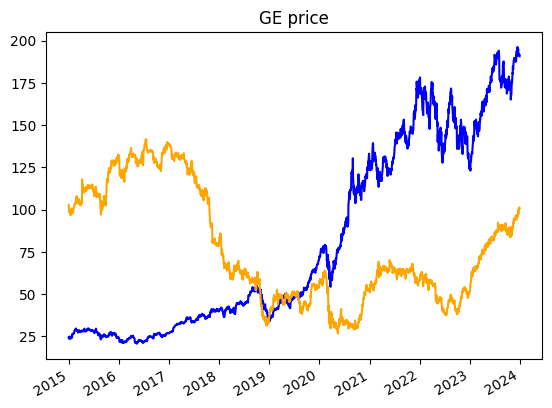

In [29]:
prices_appl["Close"].plot(title="AAPL price", color="b")
prices_ge["Close"].plot(title="GE price", color="orange")

<br><br><br><br>
<h3>Extracting log returns</h3>

In [7]:
returns_aapl = np.log(prices_appl["Close"]).diff().dropna()
returns_ge   = np.log(prices_ge["Close"]).diff().dropna()

<Axes: title={'center': 'AAPL log returns'}>

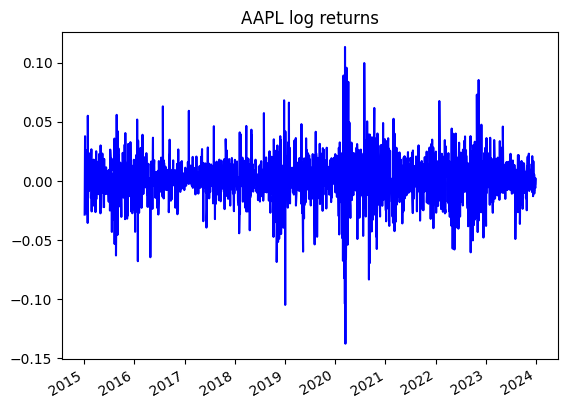

In [30]:
returns_aapl.plot(title="AAPL log returns", color="b")


<Axes: title={'center': 'GE log returns'}>

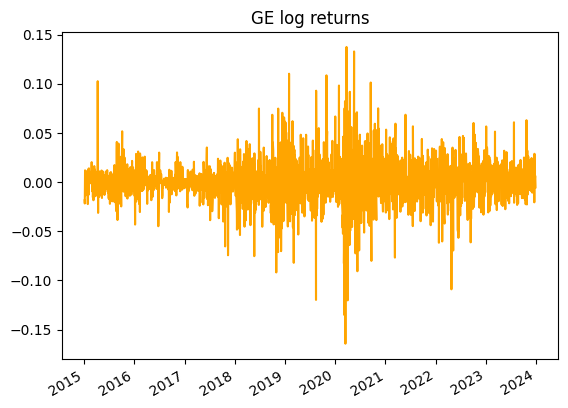

In [27]:
returns_ge.plot(title="GE log returns", color="orange")

<br><br><br><br>
<h2>2. Analyzing distribution of returns</h2>

<br><br><br><br>
<h3>Distribution of returns</h3>

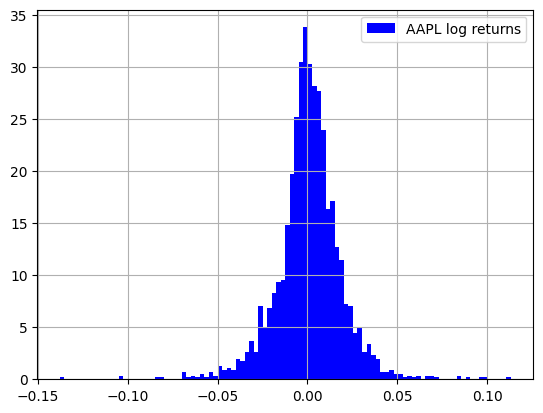

In [39]:
returns_aapl.hist(bins=100, density=True, color='b', label='AAPL log returns')
plt.legend()

<br><br><br><br>
<p>Fitting distributions to APPL log-returns</p>

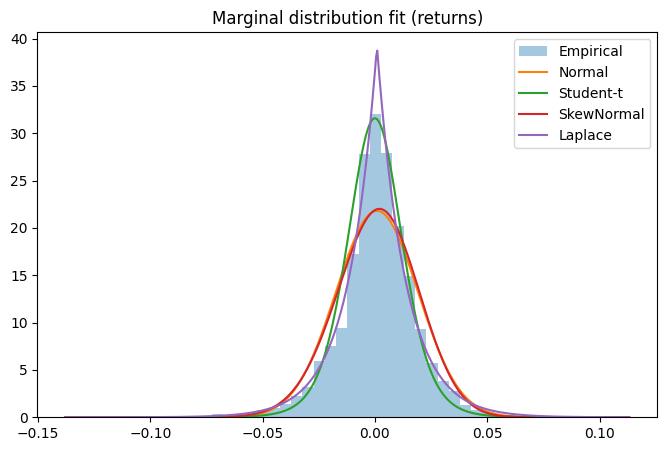

,Distribution,KS statistic,p-value
3,Laplace,0.026780,7.646080e-02
1,Student-t,0.043607,3.543307e-04
2,SkewNormal,0.073550,4.312240e-11
0,Normal,0.078794,1.145763e-12


In [43]:

# Choose returns (assumed already computed)
x = returns_aapl.values
x = x[np.isfinite(x)]

# Candidate distributions
distributions = {
    "Normal": stats.norm,
    "Student-t": stats.t,
    "SkewNormal": stats.skewnorm,
    "Laplace": stats.laplace
}

results = []

# Grid-search df for Student-t (optional, otherwise MLE handles it)
t_df_grid = [3, 5, 8, 12, 20]

# Histogram base
plt.figure(figsize=(8, 5))
plt.hist(x, bins=50, density=True, alpha=0.4, label="Empirical")

xx = np.linspace(x.min(), x.max(), 500)

for name, dist in distributions.items():
    if name == "Student-t":
        best = None

        for df in t_df_grid:
            params = (df,) + dist.fit(x, floc=0)[1:]
            ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

            if best is None or ks_stat < best["ks"]:
                best = {"params": params, "ks": ks_stat, "pval": pval}

        params = best["params"]
        ks_stat = best["ks"]
        pval = best["pval"]

    else:
        params = dist.fit(x)
        ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

    results.append({
        "Distribution": name,
        "KS statistic": ks_stat,
        "p-value": pval
    })

    pdf = dist.pdf(xx, *params)
    plt.plot(xx, pdf, label=f"{name}")

plt.title("Marginal distribution fit (returns)")
plt.legend()
plt.show()

# Display results
results_df = pd.DataFrame(results).sort_values("KS statistic")
results_df

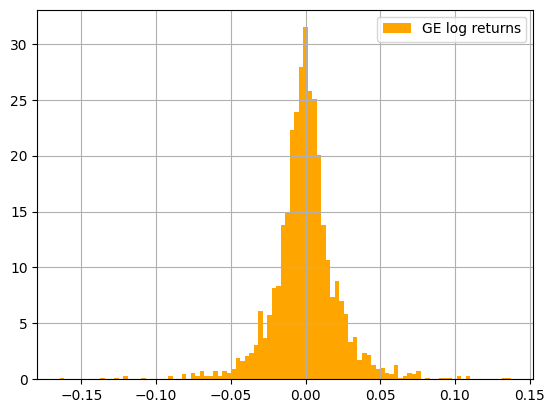

In [36]:
returns_ge.hist(bins=100, density=True, color='orange', label='GE log returns')
plt.legend()

<br><br><br><br>
<p>Fitting distributions to GE log-returns</p>

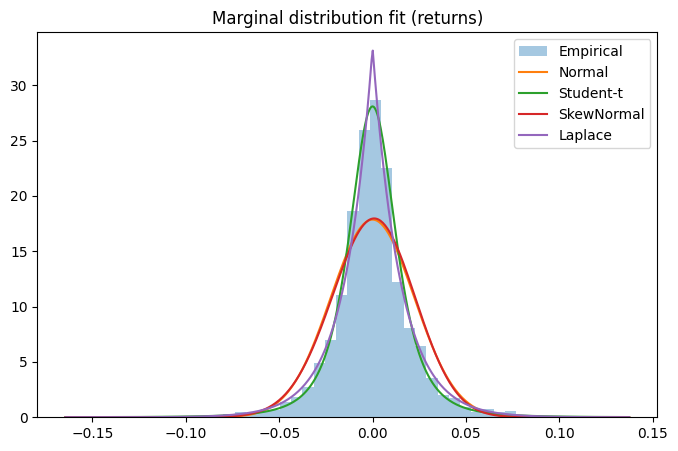

,Distribution,KS statistic,p-value
3,Laplace,0.020225,3.086964e-01
1,Student-t,0.021033,2.656730e-01
0,Normal,0.091438,6.473858e-17
2,SkewNormal,0.093171,1.511643e-17


In [44]:

# Choose returns (assumed already computed)
x = returns_ge.values
x = x[np.isfinite(x)]

# Candidate distributions
distributions = {
    "Normal": stats.norm,
    "Student-t": stats.t,
    "SkewNormal": stats.skewnorm,
    "Laplace": stats.laplace
}

results = []

# Grid-search df for Student-t (optional, otherwise MLE handles it)
t_df_grid = [3, 5, 8, 12, 20]

# Histogram base
plt.figure(figsize=(8, 5))
plt.hist(x, bins=50, density=True, alpha=0.4, label="Empirical")

xx = np.linspace(x.min(), x.max(), 500)

for name, dist in distributions.items():
    if name == "Student-t":
        best = None

        for df in t_df_grid:
            params = (df,) + dist.fit(x, floc=0)[1:]
            ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

            if best is None or ks_stat < best["ks"]:
                best = {"params": params, "ks": ks_stat, "pval": pval}

        params = best["params"]
        ks_stat = best["ks"]
        pval = best["pval"]

    else:
        params = dist.fit(x)
        ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

    results.append({
        "Distribution": name,
        "KS statistic": ks_stat,
        "p-value": pval
    })

    pdf = dist.pdf(xx, *params)
    plt.plot(xx, pdf, label=f"{name}")

plt.title("Marginal distribution fit (returns)")
plt.legend()
plt.show()

# Display results
results_df = pd.DataFrame(results).sort_values("KS statistic")
results_df

<br><br><br><br>
<h3>Correlation of returns</h3>

In [42]:
R = pd.concat([returns_aapl, returns_ge], axis=1).dropna()
R.columns = ["AAPL", "GE"]

R.corr()

,AAPL,GE
AAPL,1.000000,0.349112
GE,0.349112,1.000000


<br><br><br><br>
<h3>ACF and Absolute ACF of log returns</h3>

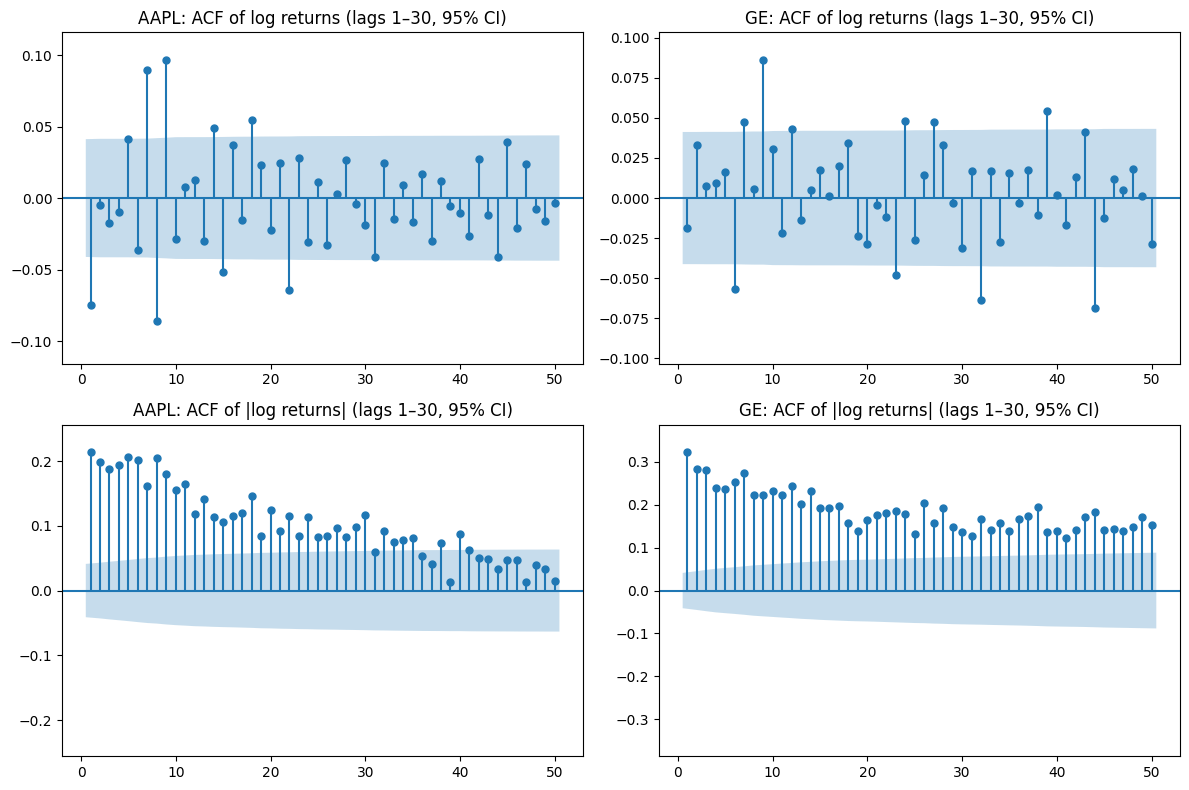

In [52]:
lags = 50
conf_level = 0.95

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

def plot_acf_scaled(series, ax, title):
    plot_acf(
        series,
        lags=lags,
        ax=ax,
        zero=False,
        alpha=1 - conf_level
    )

    # Get current y-data limits from plotted lines
    lines = ax.lines
    y_vals = np.concatenate([line.get_ydata() for line in lines if len(line.get_ydata()) > 0])

    # Add padding
    ymax = np.max(np.abs(y_vals))
    ax.set_ylim(-1.2 * ymax, 1.2 * ymax)

    ax.set_title(title)


# --- AAPL ---
plot_acf_scaled(
    returns_aapl,
    axes[0, 0],
    "AAPL: ACF of log returns (lags 1–30, 95% CI)"
)

plot_acf_scaled(
    abs(returns_aapl),
    axes[1, 0],
    "AAPL: ACF of |log returns| (lags 1–30, 95% CI)"
)

# --- GE ---
plot_acf_scaled(
    returns_ge,
    axes[0, 1],
    "GE: ACF of log returns (lags 1–30, 95% CI)"
)

plot_acf_scaled(
    abs(returns_ge),
    axes[1, 1],
    "GE: ACF of |log returns| (lags 1–30, 95% CI)"
)

plt.tight_layout()
plt.show()

<br><br><br><br>
<h2>3. Fitting marginal distributions</h2>

<br><br><br><br>
<h2>3. Fitting models to return time series</h2>

<br><br><br><br>
<h3>Fitting mean functions</h3>

<br><br><br><br>
APPL returns mean

In [54]:

x = returns_aapl.values
x = x[np.isfinite(x)]

n = len(x)
mu_hat = x.mean()
sigma_hat = x.std(ddof=1)
se = sigma_hat / np.sqrt(n)
t_stat = mu_hat / se
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 1))

results = pd.DataFrame(
    {
        "Estimate": [mu_hat],
        "Std. Error": [se],
        "t-stat": [t_stat],
        "p-value": [p_value],
        "N": [n],
    },
    index=["Mean return"]
)

results

,Estimate,Std. Error,t-stat,p-value,N
Mean return,0.000912,0.000385,2.369759,0.017883,2263


<br><br><br><br>
GE returns mean

In [55]:

x = returns_ge.values
x = x[np.isfinite(x)]

n = len(x)
mu_hat = x.mean()
sigma_hat = x.std(ddof=1)
se = sigma_hat / np.sqrt(n)
t_stat = mu_hat / se
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 1))

results = pd.DataFrame(
    {
        "Estimate": [mu_hat],
        "Std. Error": [se],
        "t-stat": [t_stat],
        "p-value": [p_value],
        "N": [n],
    },
    index=["Mean return"]
)

results

,Estimate,Std. Error,t-stat,p-value,N
Mean return,-0.000009,0.00047,-0.01816,0.985513,2263


<br><br><br><br><br>
<b>ASSUMPTION/CONCLUSION:</b> I will assume mean is zero for both APPL and GE

<br><br><br><br>
<h3>Fitting heteroskedastic volatility models</h3>

Function for grid search of ARCH/GARCH models and Normal vs. Student-t distribution

In [64]:
def fit_vol_models(returns, asset_name):
    rows = []
    fitted_models = {}

    model_grid = [
        {"vol": "ARCH", "p": 1, "q": 0},
        {"vol": "ARCH", "p": 2, "q": 0},
        {"vol": "ARCH", "p": 3, "q": 0},
        {"vol": "GARCH", "p": 1, "q": 1},
        {"vol": "GARCH", "p": 1, "q": 2},
        {"vol": "GARCH", "p": 2, "q": 1},
    ]

    dists = ["normal", "t"]

    for spec in model_grid:
        for dist in dists:
            try:
                am = arch_model(
                    returns,
                    mean="Constant",
                    vol=spec["vol"],
                    p=spec["p"],
                    q=spec["q"],
                    dist=dist,
                )
                res = am.fit(disp="off")

                z = res.std_resid.dropna()

                lb_z = acorr_ljungbox(z, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
                lb_z2 = acorr_ljungbox(z**2, lags=[10], return_df=True)["lb_pvalue"].iloc[0]

                model_name = f"{spec['vol']}({spec['p']},{spec['q']})"

                rows.append({
                    "Asset": asset_name,
                    "Model": model_name,
                    "Dist": dist,
                    "AIC": res.aic,
                    "LB(z) pval": lb_z,
                    "LB(z^2) pval": lb_z2,
                    "alpha+beta": (
                        res.params.get("alpha[1]", 0) + res.params.get("beta[1]", 0)
                        if spec["vol"] == "GARCH" else None
                    ),
                })

                # ⭐ store fitted model
                fitted_models[(model_name, dist)] = res

            except Exception:
                continue

    results_df = pd.DataFrame(rows).sort_values("AIC")
    return results_df, fitted_models


<br><br><br><br>
Rescaling returns dataframes for better parameter estimation

In [67]:
returns_aapl_scaled = 100 * returns_aapl
returns_ge_scaled   = 100 * returns_ge

<br><br><br><br>
APPL volatility model grid search

In [73]:
results_aapl, models_appl = fit_vol_models(returns_aapl_scaled, "AAPL")
results_aapl

,Asset,Model,Dist,AIC,LB(z) pval,LB(z^2) pval,alpha+beta
7,AAPL,"GARCH(1,1)",t,8497.001422,0.116330,9.738977e-01,0.983071
9,AAPL,"GARCH(1,2)",t,8498.299824,0.116724,9.748873e-01,0.754416
11,AAPL,"GARCH(2,1)",t,8499.001422,0.116327,9.739003e-01,0.983073
5,AAPL,"ARCH(3,0)",t,8601.345938,0.081702,1.251603e-02,NaN
3,AAPL,"ARCH(2,0)",t,8633.416731,0.019730,1.252513e-06,NaN
6,AAPL,"GARCH(1,1)",normal,8676.709949,0.127163,9.832052e-01,0.957741
10,AAPL,"GARCH(2,1)",normal,8678.473463,0.126867,9.807713e-01,0.941262
8,AAPL,"GARCH(1,2)",normal,8678.709949,0.127163,9.832050e-01,0.957741
1,AAPL,"ARCH(1,0)",t,8682.045427,0.003530,2.988241e-38,NaN
4,AAPL,"ARCH(3,0)",normal,8836.311000,0.048916,9.291004e-04,NaN


<br><br><br><br>
GE volatility model grid search

In [74]:
results_ge, models_ge = fit_vol_models(returns_ge_scaled, "GE")
results_ge

,Asset,Model,Dist,AIC,LB(z) pval,LB(z^2) pval,alpha+beta
9,GE,"GARCH(1,2)",t,9020.383231,0.702354,7.716676e-01,0.429247
7,GE,"GARCH(1,1)",t,9024.900353,0.787241,5.225391e-01,1.000000
11,GE,"GARCH(2,1)",t,9026.900354,0.787233,5.225405e-01,1.000000
5,GE,"ARCH(3,0)",t,9181.692898,0.291975,1.541802e-01,NaN
3,GE,"ARCH(2,0)",t,9254.909187,0.134849,3.147569e-06,NaN
8,GE,"GARCH(1,2)",normal,9307.448261,0.564850,7.886451e-01,0.403797
1,GE,"ARCH(1,0)",t,9312.607727,0.005298,3.333023e-15,NaN
6,GE,"GARCH(1,1)",normal,9319.184029,0.646146,5.560989e-01,0.996535
10,GE,"GARCH(2,1)",normal,9321.184029,0.646142,5.561035e-01,0.996535
4,GE,"ARCH(3,0)",normal,9530.727678,0.211020,1.307031e-01,NaN


<br><br><br><br><br>
<b>ASSUMPTION/CONCLUSION:</b> <br>
APPL vol. model: GARCH(1,1), student-t innovations<br>
GE vol. model: GARCH(1,2), student-t innovations<br>

<br><br><br><br>
Picking best volatility model for each stock

In [ ]:
best_specs = {
    "AAPL": results_aapl.iloc[0],
    "GE": results_ge.iloc[0],
}

best_res = {
    "AAPL": models_appl[
        (best_specs["AAPL"]["Model"], best_specs["AAPL"]["Dist"])
    ],
    "GE": models_ge[
        (best_specs["GE"]["Model"], best_specs["GE"]["Dist"])
    ],
}


<br><br><br><br>
<h3>Extracting residuals and volatility time series from volatility models</h3>

<br><br><br><br>
Function for volatility and residual extraction

In [85]:
def extract_vol_and_residuals(returns, res, scale=100.0):
    """
    returns: unscaled returns Series (log returns)
    res: ARCHModelResult fitted on scaled returns (e.g. 100*returns)
    scale: scaling factor used in fitting
    """
    df = pd.DataFrame(index=returns.index)

    df["return"] = returns
    df["sigma"] = res.conditional_volatility / scale
    df["resid"] = res.resid / scale
    df["z"] = res.std_resid

    # PIT using the fitted innovation distribution
    dist = res.model.distribution
    dist_params = res.params[dist.parameter_names()].to_numpy()
    df["u"] = dist.cdf(df["z"].to_numpy(), dist_params)

    return df.dropna()

<br><br><br><br>
Extracting residuals and volatility

In [86]:
aapl_garch = extract_vol_and_residuals(returns_aapl, best_res["AAPL"])
ge_garch   = extract_vol_and_residuals(returns_ge, best_res["GE"])

<br><br><br><br>
Function for plotting residuals and volatility

In [96]:
def plot_garch_parts(df, mu=0.0, title_prefix=""):
    """
    df must contain:
        - return : original returns
        - sigma  : conditional volatility
        - z      : standardized residuals
    mu: mean return (in original units)
    """

    upper = mu + 2 * df["sigma"]
    lower = mu - 2 * df["sigma"]

    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    # 1️⃣ Returns with volatility bands
    df["return"].plot(ax=axes[0], label="r_t", alpha=0.8)
    upper.plot(ax=axes[0], linestyle="--", color="red", alpha=0.8, label="μ ± 2σ_t")
    lower.plot(ax=axes[0], linestyle="--", color="red", alpha=0.8)
    axes[0].set_title(f"{title_prefix} Returns with GARCH volatility bands")
    axes[0].legend()

    # 2️⃣ Conditional volatility
    df["sigma"].plot(ax=axes[1])
    axes[1].set_title(f"{title_prefix} Conditional volatility σ_t")

    # 3️⃣ Standardized residuals (this is the key!)
    df["z"].plot(ax=axes[2])
    axes[2].set_title(f"{title_prefix} Standardized residuals z_t = ε_t / σ_t")

    plt.tight_layout()
    plt.show()


<br><br><br><br>
APPL residuals and volatility

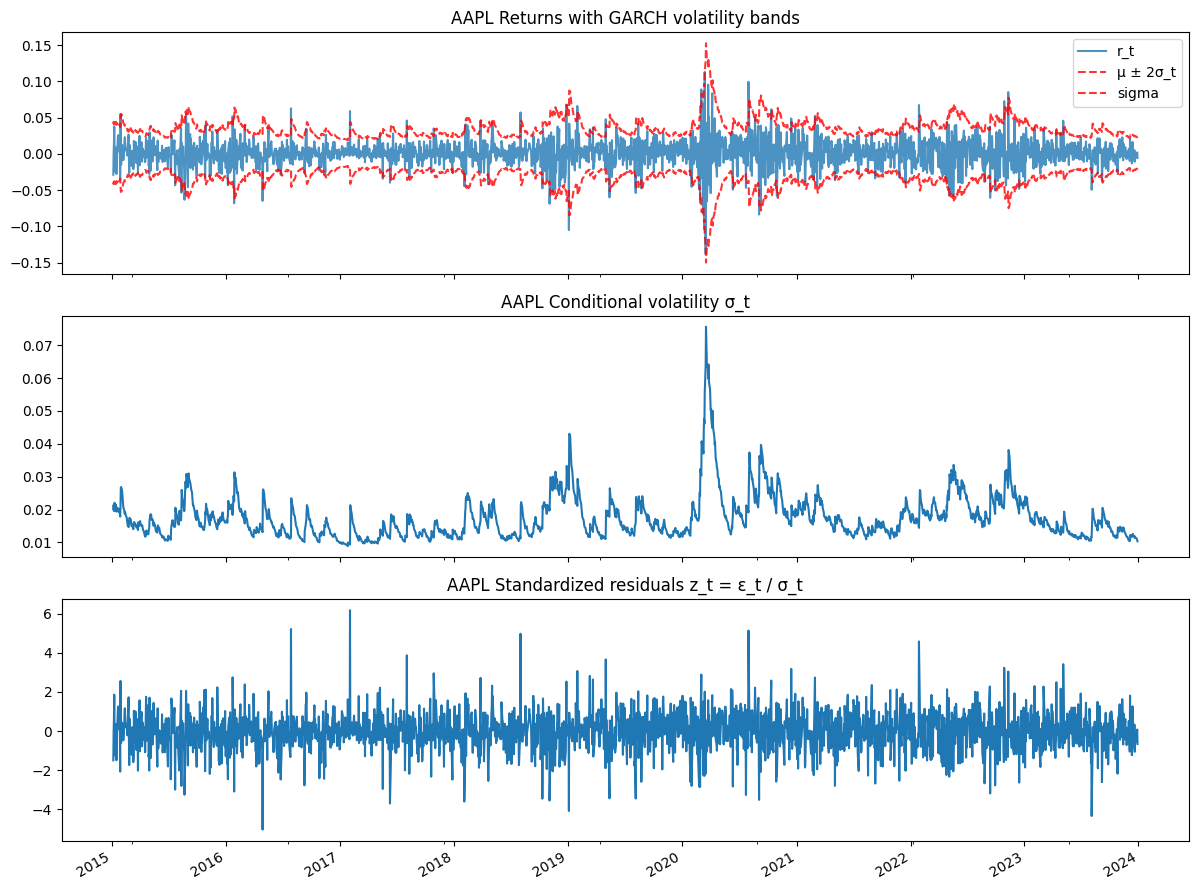

In [97]:
mu_aapl = best_res["AAPL"].params.get("mu", 0.0) / 100.0

plot_garch_parts(
    aapl_garch,
    mu=mu_aapl,
    title_prefix="AAPL"
)


<br><br><br><br>
GE residuals and volatility

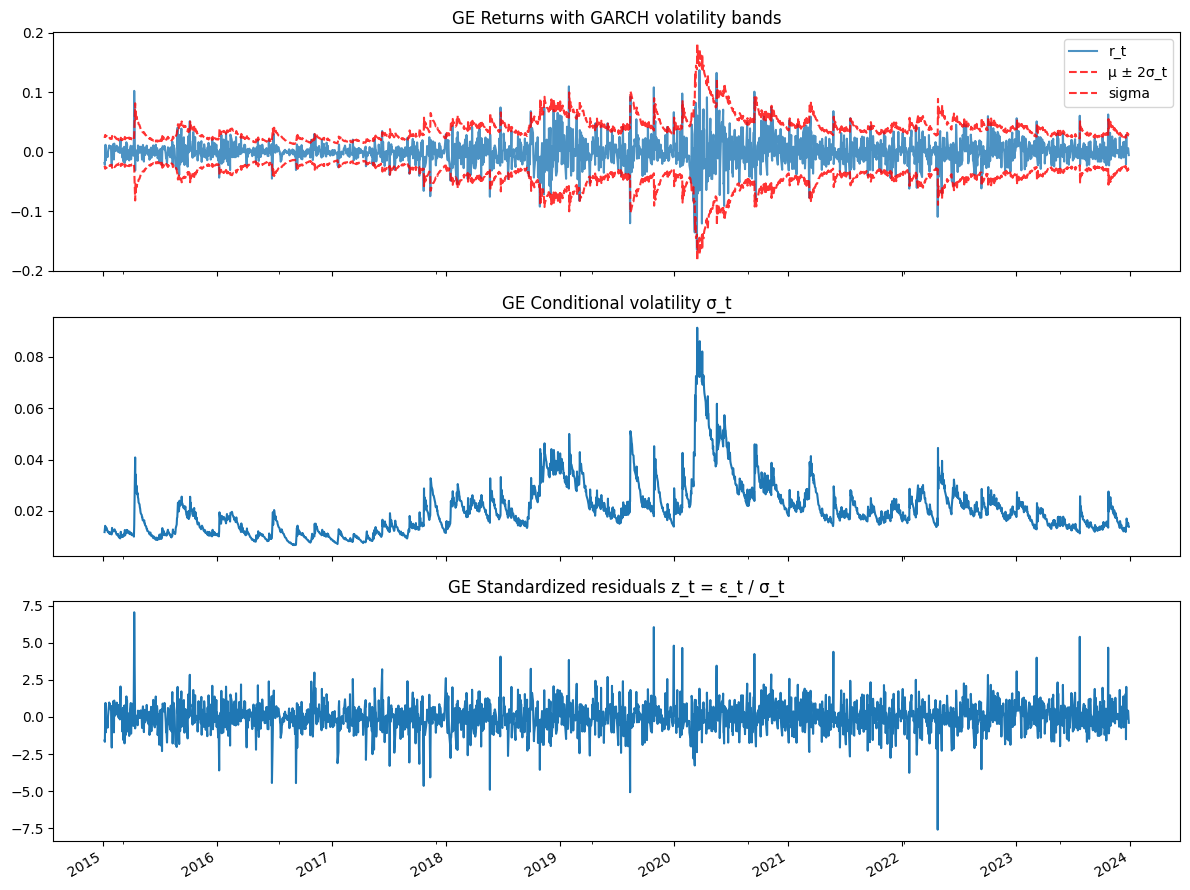

In [98]:
mu_ge = best_res["GE"].params.get("mu", 0.0) / 100.0

plot_garch_parts(
    ge_garch,
    mu=mu_ge,
    title_prefix="GE"
)



<br><br><br><br>
<h3>Checking standardized residuals for i.i.d. noise</h3>

<br><br><br><br>
Function for checking i.i.d. nature and PDF of standardized residuals

In [ ]:

def innovation_diagnostics(df, res, name="", lags=35, conf_level=0.95, bins=60):
    z = df["z"].dropna().to_numpy()

    # Ljung–Box tests
    lb_z  = acorr_ljungbox(z, lags=[lags], return_df=True)["lb_pvalue"].iloc[0]
    lb_abs = acorr_ljungbox(np.abs(z), lags=[lags], return_df=True)["lb_pvalue"].iloc[0]
    lb_z2 = acorr_ljungbox(z**2, lags=[lags], return_df=True)["lb_pvalue"].iloc[0]

    # Get the fitted innovation distribution info from arch
    dist = res.model.distribution
    dist_name = getattr(dist, "name", dist.__class__.__name__)

    # Params for distribution (e.g., nu for Student-t)
    param_names = dist.parameter_names()
    dist_params = res.params[param_names].to_numpy() if len(param_names) > 0 else np.array([])

    # CDF function (arch provides this)
    cdf_func = lambda x: dist.cdf(np.asarray(x), dist_params)

    # KS test vs fitted CDF (p-value approximate due to estimated params)
    ks_stat, ks_pval = stats.kstest(z, cdf_func)

    # Plot ACF(z), ACF(|z|), histogram + fitted PDF (scipy for normal/t)
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    plot_acf(z, lags=lags, zero=False, alpha=1-conf_level, ax=axes[0])
    axes[0].set_title(f"{name} ACF of z_t (lags 1–{lags}, {int(conf_level*100)}% CI)")

    plot_acf(np.abs(z), lags=lags, zero=False, alpha=1-conf_level, ax=axes[1])
    axes[1].set_title(f"{name} ACF of |z_t| (lags 1–{lags}, {int(conf_level*100)}% CI)")

    # Histogram + pdf overlay
    xx = np.linspace(np.percentile(z, 0.5), np.percentile(z, 99.5), 500)
    axes[2].hist(z, bins=bins, density=True, alpha=0.4, label="z_t (empirical)")

    # Try to overlay a PDF using SciPy for common distributions
    overlay_done = False
    if "student" in dist_name.lower() or dist_name.lower() in ["t", "studentst"]:
        # arch Student-t uses df parameter nu
        nu = float(dist_params[0]) if dist_params.size > 0 else None
        if nu is not None:
            axes[2].plot(xx, stats.t.pdf(xx, df=nu), label=f"Student-t pdf (nu={nu:.2f})")
            overlay_done = True

    elif "normal" in dist_name.lower() or dist_name.lower() in ["gaussian", "normal"]:
        axes[2].plot(xx, stats.norm.pdf(xx, loc=0, scale=1), label="Normal pdf (0,1)")
        overlay_done = True

    if not overlay_done:
        axes[2].text(
            0.02, 0.95,
            f"No SciPy pdf overlay for dist='{dist_name}'",
            transform=axes[2].transAxes,
            va="top"
        )

    axes[2].set_title(f"{name} innovation fit\nKS={ks_stat:.4f}, p={ks_pval:.2e}")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    print(f"=== {name} innovation diagnostics ===")
    print(f"Ljung–Box p-value on z_t   (want high): {lb_z:.4f}")
    print(f"Ljung–Box p-value on |z_t| (want high): {lb_abs:.4f}")
    print(f"Ljung–Box p-value on z_t^2 (want high): {lb_z2:.4f}")
    print(f"KS vs fitted {dist_name}: statistic={ks_stat:.4f}, p={ks_pval:.2e}")
    print("\nRules of thumb:")
    print("- Ljung–Box: p > 0.05 (or 0.10) ⇒ no evidence of leftover autocorrelation.")
    print("- KS: p > 0.05 would be 'not rejected', BUT p-values are approximate when params are estimated.")
    print("  Use KS mainly to compare distributions + rely on the overlay and Ljung–Box on z^2.\n")

    return {
        "lb_z_pval": lb_z,
        "lb_absz_pval": lb_abs,
        "lb_z2_pval": lb_z2,
        "ks_stat": ks_stat,
        "ks_pval": ks_pval,
        "dist_name": dist_name,
        "dist_params": dist_params
    }


<br><br><br><br>
Checking AAPL standardized residuals

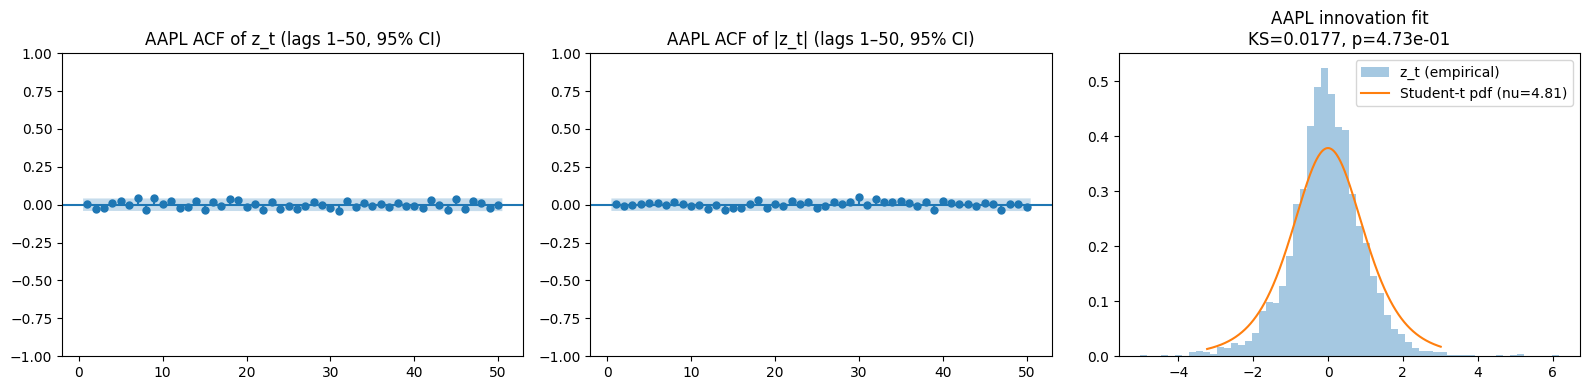

=== AAPL innovation diagnostics ===
Ljung–Box p-value on z_t   (want high): 0.1772
Ljung–Box p-value on |z_t| (want high): 0.9083
Ljung–Box p-value on z_t^2 (want high): 0.9972
KS vs fitted Standardized Student's t: statistic=0.0177, p=4.73e-01

Rules of thumb:
- Ljung–Box: p > 0.05 (or 0.10) ⇒ no evidence of leftover autocorrelation.
- KS: p > 0.05 would be 'not rejected', BUT p-values are approximate when params are estimated.
  Use KS mainly to compare distributions + rely on the overlay and Ljung–Box on z^2.



In [110]:
diag_aapl = innovation_diagnostics(aapl_garch, best_res["AAPL"], name="AAPL", lags=50)

<br><br><br><br>
Checking GE standardized residuals

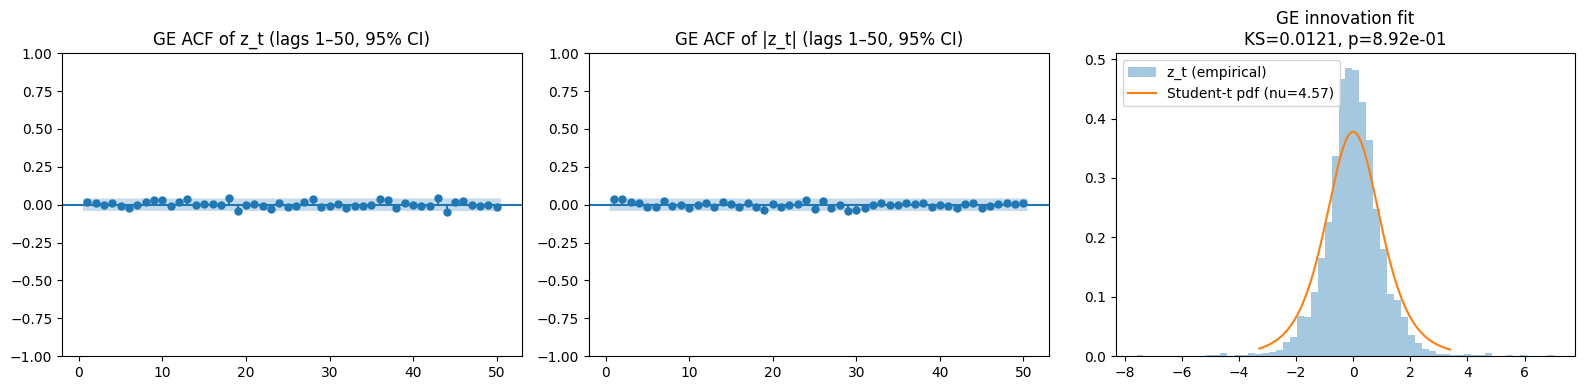

=== GE innovation diagnostics ===
Ljung–Box p-value on z_t   (want high): 0.5004
Ljung–Box p-value on |z_t| (want high): 0.9380
Ljung–Box p-value on z_t^2 (want high): 0.9989
KS vs fitted Standardized Student's t: statistic=0.0121, p=8.92e-01

Rules of thumb:
- Ljung–Box: p > 0.05 (or 0.10) ⇒ no evidence of leftover autocorrelation.
- KS: p > 0.05 would be 'not rejected', BUT p-values are approximate when params are estimated.
  Use KS mainly to compare distributions + rely on the overlay and Ljung–Box on z^2.



In [109]:
a = innovation_diagnostics(ge_garch,   best_res["GE"],   name="GE",   lags=50)

<br><br><br><br>
<h2>4. Modeling asset dependence via a copula</h2>

<br><br><br><br>
<h3>Creating uniforms from marginal distributions</h3>

<br><br><br><br>
Function for creating uniform marginals from standardized residuals.

In [112]:
def prep_uniform_marginals(
    series: Dict[str, Union[pd.Series, pd.DataFrame]],
    u_col: str = "u",
    how: str = "inner",
    clip_eps: float = 1e-10,
    dropna: bool = True,
    ensure_unique_index: bool = True,
    sort_index: bool = True,
) -> pd.DataFrame:
    """
    Build an aligned U-matrix of PIT uniforms for copula estimation.

    Parameters
    ----------
    series : dict
        Mapping name -> object containing PIT uniforms.
        Each value can be:
          - pd.Series of u_t
          - pd.DataFrame with a column `u_col` (default "u")
    u_col : str
        Column to read from DataFrames.
    how : {"inner","outer","left","right"}
        Join mode used when aligning indices.
        Use "inner" for copulas (recommended).
    clip_eps : float
        Clips U to [eps, 1-eps] to avoid inf in inverse-CDF transforms.
        Set to None to disable clipping.
    dropna : bool
        Drop rows with NaNs after alignment.
    ensure_unique_index : bool
        Enforce unique time index per series (keeps last if duplicates exist).
    sort_index : bool
        Sort final DataFrame by index.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns as provided keys and values in (0,1).
    """
    if not isinstance(series, dict) or len(series) == 0:
        raise ValueError("series must be a non-empty dict: name -> (Series or DataFrame with u).")

    cols = []
    for name, obj in series.items():
        if isinstance(obj, pd.DataFrame):
            if u_col not in obj.columns:
                raise KeyError(f"{name}: DataFrame missing column '{u_col}'. Available: {list(obj.columns)}")
            u = obj[u_col].copy()
        elif isinstance(obj, pd.Series):
            u = obj.copy()
        else:
            raise TypeError(f"{name}: expected pd.Series or pd.DataFrame, got {type(obj)}")

        u = pd.to_numeric(u, errors="coerce")
        u.name = name

        if ensure_unique_index:
            # Keep last observation if duplicate timestamps exist
            u = u[~u.index.duplicated(keep="last")]

        cols.append(u)

    # Align all series
    U = pd.concat(cols, axis=1, join=how)

    if sort_index:
        U = U.sort_index()

    if dropna:
        U = U.dropna()

    if clip_eps is not None:
        if not (0 < clip_eps < 0.5):
            raise ValueError("clip_eps must be in (0, 0.5).")
        U = U.clip(lower=clip_eps, upper=1.0 - clip_eps)

    # Basic validity checks
    if (U <= 0).any().any() or (U >= 1).any().any():
        bad = ((U <= 0) | (U >= 1)).sum()
        raise ValueError(
            "U contains values at/ outside (0,1) after clipping/checks. "
            f"Counts per column:\n{bad}"
        )

    return U


def summarize_uniforms(U: pd.DataFrame) -> pd.DataFrame:
    """
    Quick diagnostics summary table for copula inputs.
    """
    if not isinstance(U, pd.DataFrame) or U.shape[1] < 2:
        raise ValueError("U must be a DataFrame with >=2 columns.")

    summary = pd.DataFrame({
        "n": U.notna().sum(),
        "min": U.min(),
        "p01": U.quantile(0.01),
        "p05": U.quantile(0.05),
        "mean": U.mean(),
        "p50": U.quantile(0.50),
        "p95": U.quantile(0.95),
        "p99": U.quantile(0.99),
        "max": U.max(),
    })
    return summary


<br><br><br><br>
Creating uniform marginals for AAPL and GE in a dataframe, U

In [115]:
U = prep_uniform_marginals({
    "u_aapl": aapl_garch,   # DataFrame with column "u"
    "u_ge":   ge_garch,     # DataFrame with column "u"
})

display(summarize_uniforms(U))
U.head(), U.shape


,n,min,p01,p05,mean,p50,p95,p99,max
u_aapl,2263,0.000704,0.008090,0.042088,0.494157,0.484401,0.944500,0.986907,0.999718
u_ge,2263,0.000134,0.010601,0.043607,0.498213,0.497532,0.953359,0.989070,0.999815


(              u_aapl      u_ge
 2015-01-05  0.055159  0.047179
 2015-01-06  0.470167  0.040715
 2015-01-07  0.772522  0.512792
 2015-01-08  0.969431  0.866019
 2015-01-09  0.492990  0.115419,
 (2263, 2))

<br><br><br><br>
Function for sanity check on the uniform marginals

In [121]:


def pit_quality_report(
    U: pd.DataFrame,
    lags: int = 20,
    do_ks: bool = True,
    ks_alpha_note: bool = True,
) -> pd.DataFrame:
    """
    Quick PIT diagnostics per column in U.

    - min/max to ensure in (0,1)
    - KS vs Uniform(0,1) (diagnostic; parameters are estimated upstream)
    - Ljung-Box on normal scores x = Phi^{-1}(u) to check leftover serial dependence

    Returns a tidy table.
    """
    out = []
    eps = 1e-12

    for col in U.columns:
        u = U[col].dropna().to_numpy()
        u = np.clip(u, eps, 1 - eps)

        # Normal scores often behave better for serial tests
        x = norm.ppf(u)

        # Ljung-Box
        lb = acorr_ljungbox(x, lags=[lags], return_df=True)
        lb_p = float(lb["lb_pvalue"].iloc[0])

        row = {
            "col": col,
            "n": len(u),
            "min": float(u.min()),
            "max": float(u.max()),
            "mean": float(u.mean()),
            "lb_pvalue_normscores": lb_p,
        }

        if do_ks:
            ks = kstest(u, uniform(loc=0, scale=1).cdf)
            row["ks_stat"] = float(ks.statistic)
            row["ks_pvalue"] = float(ks.pvalue)

        out.append(row)

    df = pd.DataFrame(out).set_index("col")
    return df


<br><br><br><br>
Sanity check on the uniform marginals

In [123]:
pit_quality_report(U, lags=20)


,n,min,max,mean,lb_pvalue_normscores,ks_stat,ks_pvalue
col,,,,,,,
u_aapl,2263,0.000704,0.999718,0.494157,0.127140,0.017685,0.473277
u_ge,2263,0.000134,0.999815,0.498213,0.440123,0.012086,0.891522


<br><br><br><br>
<h3>Analyzing uniforms marginals and fitting copula</h3>

<br><br><br><br>
Function for isualizing uniform marginals and calculating Spearman's Roe and Kendall's Tau

In [128]:
def copula_input_diagnostics(
    U: pd.DataFrame,
    bins: int = 40,
    pairs: list[tuple[str, str]] | None = None,
    tail_qs: tuple[float, ...] = (0.10, 0.05, 0.02),
    show_scatter: bool = True,
    show_lambda_curve: bool = True,
    show_chi_plot: bool = True,
    max_scatter_points: int = 6000,
) -> None:
    """
    Copula-oriented diagnostics on PIT uniforms U.

    Adds book-style dependence diagnostics that can inform copula choice:
      - rank measures: Kendall tau, Spearman rho
      - Gaussian score correlation (corr of Phi^{-1}(U)) -> Gaussian copula parameter proxy
      - tail co-movement proxies: lambda_L(q), lambda_U(q) across q
      - chi-plot style diagnostic (departure from independence)
      - optional scatter (U-space + normal-score space)

    Notes
    -----
    - These are diagnostics to *restrict candidate copulas*, not a formal selection rule.
    - Tail proxies help decide Gaussian vs t, and whether asymmetry might matter.
    """
    if not isinstance(U, pd.DataFrame) or U.shape[1] < 2:
        raise ValueError("U must be a DataFrame with at least 2 columns of uniforms.")

    # ---- 1) Univariate PIT sanity (histograms) ----
    U.hist(bins=bins, figsize=(10, 3))
    plt.suptitle("PIT Uniforms (Copula Inputs): univariate sanity")
    plt.tight_layout()
    plt.show()

    cols = list(U.columns)
    if pairs is None:
        pairs = [(cols[i], cols[j]) for i in range(len(cols)) for j in range(i + 1, len(cols))]

    eps = 1e-12

    for a, b in pairs:
        u1 = U[a].dropna()
        u2 = U[b].dropna()
        idx = u1.index.intersection(u2.index)
        u1 = u1.loc[idx].clip(eps, 1 - eps).to_numpy()
        u2 = u2.loc[idx].clip(eps, 1 - eps).to_numpy()

        n = len(u1)
        if n == 0:
            print(f"\n{a} vs {b}: no overlapping data.")
            continue

        # ---- 2) Rank dependence measures (copula-invariant) ----
        tau, _ = kendalltau(u1, u2)
        rho_s, _ = spearmanr(u1, u2)

        # ---- 3) Gaussian-score correlation (useful benchmark) ----
        # If the dependence is roughly elliptical, corr of normal scores is informative.
        x1 = norm.ppf(u1)
        x2 = norm.ppf(u2)
        rho_g = float(np.corrcoef(x1, x2)[0, 1])

        print(f"\n=== {a} vs {b} (n={n}) ===")
        print(f"Kendall tau      : {tau:.4f}")
        print(f"Spearman rho     : {rho_s:.4f}")
        print(f"Corr[Phi^-1(U)]  : {rho_g:.4f}   (Gaussian-copula rho proxy)")

        # ---- 4) Tail co-movement proxies: lambda_L(q), lambda_U(q) ----
        # Empirical conditional tail probabilities:
        #   lambda_L(q) ~ P(U2<=q | U1<=q)
        #   lambda_U(q) ~ P(U2>=1-q | U1>=1-q)
        # In a t-copula these stabilize >0 for small q; Gaussian tends -> 0 as q->0.
        tail_rows = []
        for q in tail_qs:
            mL = (u1 <= q)
            mU = (u1 >= 1 - q)

            lamL = np.mean(u2[mL] <= q) if mL.any() else np.nan
            lamU = np.mean(u2[mU] >= 1 - q) if mU.any() else np.nan

            tail_rows.append((q, lamL, lamU, int(mL.sum()), int(mU.sum())))

        tail_df = pd.DataFrame(tail_rows, columns=["q", "lambda_L_hat", "lambda_U_hat", "count_L", "count_U"])
        print("\nTail co-movement proxies (conditional):")
        print(tail_df.to_string(index=False, float_format=lambda x: f"{x:0.4f}"))

        # Optional: plot lambda(q) curves for a richer “tail profile”
        if show_lambda_curve:
            qs = np.linspace(0.01, 0.20, 40)
            lamL_curve = []
            lamU_curve = []
            for q in qs:
                mL = (u1 <= q)
                mU = (u1 >= 1 - q)
                lamL_curve.append(np.mean(u2[mL] <= q) if mL.any() else np.nan)
                lamU_curve.append(np.mean(u2[mU] >= 1 - q) if mU.any() else np.nan)

            plt.figure(figsize=(7, 3))
            plt.plot(qs, lamL_curve, label=r"$\hat\lambda_L(q)$")
            plt.plot(qs, lamU_curve, label=r"$\hat\lambda_U(q)$")
            plt.xlabel("q")
            plt.ylabel("conditional tail probability")
            plt.title(f"Empirical tail co-movement profile: {a} vs {b}")
            plt.ylim(0, 1)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # ---- 5) Scatter diagnostics in U-space and score-space ----
        if show_scatter:
            if n > max_scatter_points:
                # subsample for speed/overplotting
                rng = np.random.default_rng(0)
                take = rng.choice(n, size=max_scatter_points, replace=False)
                uu1, uu2 = u1[take], u2[take]
                xx1, xx2 = x1[take], x2[take]
            else:
                uu1, uu2 = u1, u2
                xx1, xx2 = x1, x2

            plt.figure(figsize=(4.2, 4.2))
            plt.scatter(uu1, uu2, s=6)
            plt.xlabel(a)
            plt.ylabel(b)
            plt.title("Copula data scatter (U-space)")
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(4.2, 4.2))
            plt.scatter(xx1, xx2, s=6)
            plt.xlabel(f"Phi^-1({a})")
            plt.ylabel(f"Phi^-1({b})")
            plt.title("Score scatter (normal-score space)")
            plt.tight_layout()
            plt.show()

        #


<br><br><br><br>
Visualizing uniform marginals and calculating Spearman's Roe and Kendall's Tau

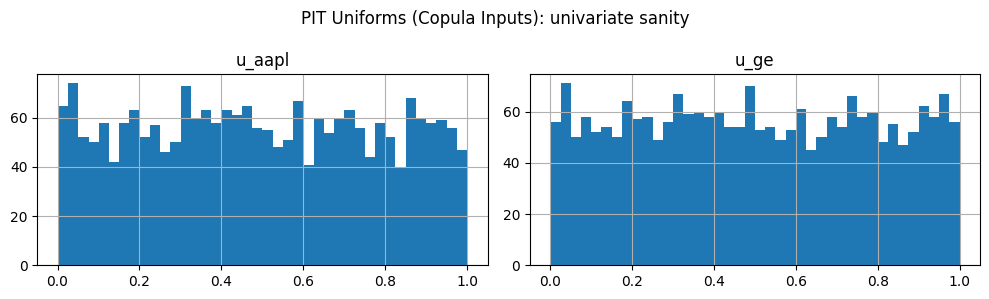


=== u_aapl vs u_ge (n=2263) ===
Kendall tau      : 0.2054
Spearman rho     : 0.2984
Corr[Phi^-1(U)]  : 0.2934   (Gaussian-copula rho proxy)

Tail co-movement proxies (conditional):
     q  lambda_L_hat  lambda_U_hat  count_L  count_U
0.1000        0.3208        0.1864      240      220
0.0500        0.2446        0.1068      139      103
0.0200        0.1765        0.0000       51       35


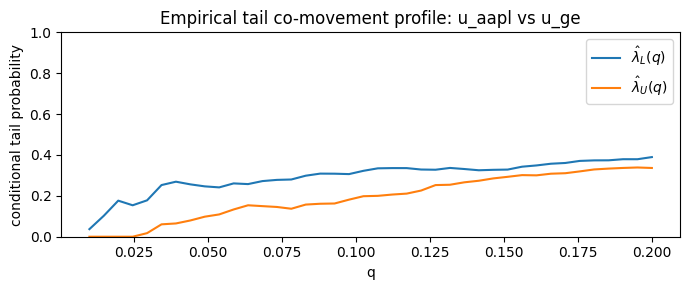

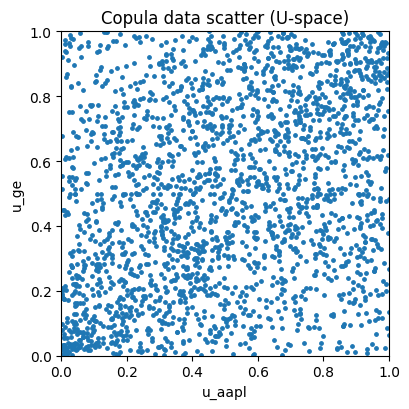

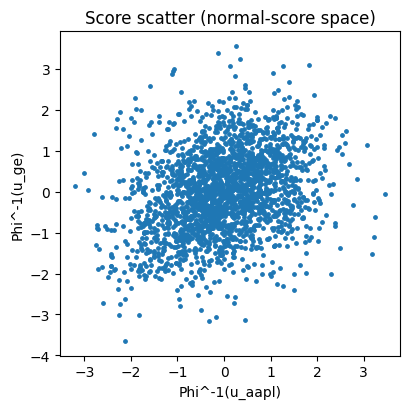

In [129]:
copula_input_diagnostics(U)


<br><br><br><br>
<h3>Function for testing fit to a set of copulas</h3>

In [148]:

# -------------------------
# Utilities
# -------------------------

def _clip_u(u, eps=1e-10):
    u = np.asarray(u, dtype=float)
    return np.clip(u, eps, 1 - eps)

def _aic(ll: float, k: int) -> float:
    return 2*k - 2*ll


# -------------------------
# Copula spec (registry item)
# -------------------------

@dataclass
class CopulaSpec:
    name: str
    k: int
    fit: Callable[[np.ndarray, np.ndarray, Dict[str, Any]], Dict[str, Any]]
    ll:  Callable[[np.ndarray, np.ndarray, Dict[str, Any]], float]
    taildep: Optional[Callable[[Dict[str, Any]], Dict[str, float]]] = None


# -------------------------
# Gaussian copula
# -------------------------

def _ll_gaussian(u1, u2, params):
    rho = float(np.clip(params["rho"], -0.9999, 0.9999))
    x1 = norm.ppf(_clip_u(u1)); x2 = norm.ppf(_clip_u(u2))
    one_m_r2 = 1.0 - rho*rho
    quad = (rho*rho*(x1*x1 + x2*x2) - 2.0*rho*x1*x2) / one_m_r2
    return float(np.sum(-0.5*np.log(one_m_r2) - 0.5*quad))

def _fit_gaussian(u1, u2, options):
    x1 = norm.ppf(_clip_u(u1)); x2 = norm.ppf(_clip_u(u2))
    rho_hat = float(np.corrcoef(x1, x2)[0, 1])
    params = {"rho": rho_hat}
    return {"params": params, "ll": _ll_gaussian(u1, u2, params), "success": True, "meta": {}}

def _taildep_gaussian(params):
    # Gaussian has zero tail dependence unless |rho|=1
    return {"lambda_L": 0.0, "lambda_U": 0.0}


# -------------------------
# Student-t copula
# -------------------------

def _log_t_copula_density(u1, u2, rho, nu):
    u1 = _clip_u(u1); u2 = _clip_u(u2)
    rho = float(np.clip(rho, -0.9999, 0.9999))
    nu = float(nu)
    if nu <= 2.0:
        return -np.inf * np.ones_like(u1)

    x1 = tdist.ppf(u1, df=nu)
    x2 = tdist.ppf(u2, df=nu)

    one_m_r2 = 1.0 - rho*rho
    Q = (x1*x1 - 2.0*rho*x1*x2 + x2*x2) / one_m_r2

    log_c2 = (
        gammaln((nu + 2.0)/2.0) - gammaln(nu/2.0)
        - np.log(nu*np.pi) - 0.5*np.log(one_m_r2)
    )
    log_f2 = log_c2 - ((nu + 2.0)/2.0) * np.log1p(Q/nu)

    log_f1_x1 = tdist.logpdf(x1, df=nu)
    log_f1_x2 = tdist.logpdf(x2, df=nu)

    return log_f2 - log_f1_x1 - log_f1_x2

def _ll_t(u1, u2, params):
    rho = params["rho"]; nu = params["nu"]
    return float(np.sum(_log_t_copula_density(u1, u2, rho, nu)))

def _fit_t(u1, u2, options):
    # options can specify nu_grid and rho_bounds
    nu_grid = options.get("nu_grid", (2.5, 3, 4, 5, 6, 8, 10, 12, 15, 20, 30, 40, 60))
    rho_bounds = options.get("rho_bounds", (-0.995, 0.995))

    best = {"ll": -np.inf, "rho": None, "nu": None, "success": False}

    for nu in nu_grid:
        def obj(rho):
            return -_ll_t(u1, u2, {"rho": rho, "nu": nu})
        res = minimize_scalar(obj, bounds=rho_bounds, method="bounded")
        ll = -float(res.fun)
        if ll > best["ll"]:
            best = {"ll": ll, "rho": float(res.x), "nu": float(nu), "success": bool(res.success)}

    params = {"rho": best["rho"], "nu": best["nu"]}
    return {"params": params, "ll": best["ll"], "success": best["success"], "meta": {"nu_grid": list(nu_grid)}}

def _taildep_t(params):
    # symmetric tail dependence for t-copula
    rho = float(params["rho"]); nu = float(params["nu"])
    a = -np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    lam = 2.0 * tdist.cdf(a, df=nu + 1.0)
    return {"lambda_L": float(lam), "lambda_U": float(lam)}

# =========================
# Archimedean copulas (book workhorses): Clayton, Gumbel, Frank (+ rotations)
# =========================

from scipy.optimize import minimize_scalar

# ---- Clayton ----

def _ll_clayton(u1, u2, params):
    # alpha in (-1,0) U (0, +inf) in the book; for finance we usually use alpha>0 (positive dep, lower-tail)
    a = float(params["alpha"])
    if a == 0.0 or a <= -1.0:
        return -np.inf
    u1 = _clip_u(u1); u2 = _clip_u(u2)
    s = u1**(-a) + u2**(-a) - 1.0
    if np.any(s <= 0):
        return -np.inf
    # log density: log(1+a) + (-1-a)(log u1 + log u2) + (-2-1/a) log s
    ll = np.sum(np.log1p(a) + (-1.0 - a)*(np.log(u1) + np.log(u2)) + (-2.0 - 1.0/a)*np.log(s))
    return float(ll)

def _fit_clayton(u1, u2, options):
    bounds = options.get("alpha_bounds", (1e-4, 50.0))
    def obj(a):
        return -_ll_clayton(u1, u2, {"alpha": a})
    res = minimize_scalar(obj, bounds=bounds, method="bounded")
    alpha_hat = float(res.x)
    params = {"alpha": alpha_hat}
    ll = _ll_clayton(u1, u2, params)
    return {"params": params, "ll": ll, "success": bool(res.success), "meta": {"alpha_bounds": bounds}}

def _taildep_clayton(params):
    # Book: lambda_L = 2^(-1/alpha) for alpha>0; lambda_U = 0
    a = float(params["alpha"])
    if a <= 0:
        return {"lambda_L": 0.0, "lambda_U": 0.0}
    return {"lambda_L": float(2.0**(-1.0/a)), "lambda_U": 0.0}

# 180° rotation of Clayton: flips tail dependence (upper instead of lower)
def _ll_clayton_180(u1, u2, params):
    # C^180(u,v) = u+v-1 + C(1-u,1-v); density equals c(1-u,1-v)
    return _ll_clayton(1.0 - _clip_u(u1), 1.0 - _clip_u(u2), params)

def _fit_clayton_180(u1, u2, options):
    fit = _fit_clayton(1.0 - _clip_u(u1), 1.0 - _clip_u(u2), options)
    # same alpha; ll should be recomputed on original u via rotated ll
    params = fit["params"]
    ll = _ll_clayton_180(u1, u2, params)
    fit.update({"ll": ll})
    return fit

def _taildep_clayton_180(params):
    td = _taildep_clayton(params)
    return {"lambda_L": 0.0, "lambda_U": td["lambda_L"]}


# ---- Gumbel (Gumbel–Hougaard) ----

def _ll_gumbel(u1, u2, params):
    alpha = float(params["alpha"])
    if alpha < 1.0:
        return -np.inf
    u1 = _clip_u(u1); u2 = _clip_u(u2)

    x = (-np.log(u1))**alpha
    y = (-np.log(u2))**alpha
    s = x + y
    s1 = s**(1.0/alpha)
    C = np.exp(-s1)

    # Stable log-density (bivariate Gumbel)
    # c(u,v)=C * ( (x y)^{1/alpha -1} / (u v) ) * s^{2/alpha -2} * ( (alpha-1) + s^{1/alpha} )
    logC = -s1
    log_term1 = (1.0/alpha - 1.0)*(np.log(x) + np.log(y)) - (np.log(u1) + np.log(u2))
    log_term2 = (2.0/alpha - 2.0)*np.log(s)
    log_term3 = np.log((alpha - 1.0) + s1)
    return float(np.sum(logC + log_term1 + log_term2 + log_term3))

def _fit_gumbel(u1, u2, options):
    bounds = options.get("alpha_bounds", (1.0 + 1e-6, 50.0))
    upper_guard_eps = options.get("upper_guard_eps", 1e-3)

    def obj(a):
        return -_ll_gumbel(u1, u2, {"alpha": a})

    res = minimize_scalar(obj, bounds=bounds, method="bounded")
    alpha_hat = float(res.x)
    params = {"alpha": alpha_hat}

    # Guard: if optimizer hits the upper bound, treat as degenerate / invalid fit
    if abs(alpha_hat - bounds[1]) < upper_guard_eps:
        return {
            "params": params,
            "ll": -np.inf,
            "success": False,
            "meta": {"alpha_bounds": bounds, "reason": "alpha hit upper bound"}
        }

    ll = _ll_gumbel(u1, u2, params)
    return {
        "params": params,
        "ll": ll,
        "success": bool(res.success) and np.isfinite(ll),
        "meta": {"alpha_bounds": bounds}
    }

def _taildep_gumbel(params):
    # Book: lambda_U = 2 - 2^(1/alpha); lambda_L = 0
    a = float(params["alpha"])
    if a <= 1.0:
        return {"lambda_L": 0.0, "lambda_U": 0.0}
    return {"lambda_L": 0.0, "lambda_U": float(2.0 - 2.0**(1.0/a))}

# 180° rotation of Gumbel: flips upper-tail -> lower-tail
def _ll_gumbel_180(u1, u2, params):
    return _ll_gumbel(1.0 - _clip_u(u1), 1.0 - _clip_u(u2), params)

def _fit_gumbel_180(u1, u2, options):
    # Fit on rotated data
    fit = _fit_gumbel(1.0 - _clip_u(u1), 1.0 - _clip_u(u2), options)

    # If the underlying fit was rejected, keep it rejected
    if not fit.get("success", True) or not np.isfinite(fit.get("ll", np.nan)):
        return fit

    params = fit["params"]
    ll = _ll_gumbel_180(u1, u2, params)
    fit.update({"ll": ll, "success": bool(fit.get("success", True)) and np.isfinite(ll)})
    return fit

def _taildep_gumbel_180(params):
    td = _taildep_gumbel(params)
    return {"lambda_L": td["lambda_U"], "lambda_U": 0.0}


# ---- Frank ----

def _ll_frank(u1, u2, params):
    alpha = float(params["alpha"])
    if alpha == 0.0:
        return -np.inf
    u1 = _clip_u(u1); u2 = _clip_u(u2)

    A  = np.exp(-alpha)
    Au = np.exp(-alpha*u1)
    Av = np.exp(-alpha*u2)

    # N = A - 1 + (Au - 1)(Av - 1)  (this is exactly the term inside the log in the CDF up to a constant)
    N = (A - 1.0) + (Au - 1.0)*(Av - 1.0)
    if np.any(N == 0):
        return -np.inf

    # Density:
    # c(u,v) = alpha (1 - e^{-alpha}) e^{-alpha(u+v)} / [ e^{-alpha} - 1 + (e^{-alpha u}-1)(e^{-alpha v}-1) ]^2
    logc = (np.log(abs(alpha)) + np.log1p(-A) - alpha*(u1 + u2) - 2.0*np.log(abs(N)))
    # Note: alpha can be negative; abs(alpha) keeps log-density finite. c(u,v) remains positive.
    return float(np.sum(logc))

def _fit_frank(u1, u2, options):
    bounds = options.get("alpha_bounds", (-50.0, 50.0))
    # Frank excludes 0; fit over negative and positive intervals and take best
    lo, hi = bounds
    eps0 = options.get("alpha_exclude_zero_eps", 1e-4)

    best = {"ll": -np.inf, "alpha": None, "success": False}

    def solve(interval):
        a_lo, a_hi = interval
        def obj(a):
            return -_ll_frank(u1, u2, {"alpha": a})
        return minimize_scalar(obj, bounds=(a_lo, a_hi), method="bounded")

    candidates = []
    if lo < -eps0:
        candidates.append(solve((lo, -eps0)))
    if hi > eps0:
        candidates.append(solve((eps0, hi)))

    for res in candidates:
        alpha_hat = float(res.x)
        ll = _ll_frank(u1, u2, {"alpha": alpha_hat})
        if ll > best["ll"]:
            best = {"ll": ll, "alpha": alpha_hat, "success": bool(res.success)}

    params = {"alpha": best["alpha"]}
    return {"params": params, "ll": best["ll"], "success": best["success"], "meta": {"alpha_bounds": bounds}}

def _taildep_frank(params):
    # Book: Frank has no lower nor upper tail dependence
    return {"lambda_L": 0.0, "lambda_U": 0.0}


# =========================
# Optional: Independence copula (product) as a baseline
# =========================

def _ll_independence(u1, u2, params):
    # density is 1, so log-likelihood is 0
    return 0.0

def _fit_independence(u1, u2, options):
    return {"params": {}, "ll": 0.0, "success": True, "meta": {}}

def _taildep_independence(params):
    return {"lambda_L": 0.0, "lambda_U": 0.0}


# -------------------------
# Registry (extended)
# -------------------------

COPULA_REGISTRY: Dict[str, CopulaSpec] = {
    "independence": CopulaSpec(
        name="independence", k=0,
        fit=_fit_independence,
        ll=_ll_independence,
        taildep=_taildep_independence
    ),
    "gaussian": CopulaSpec(
        name="gaussian", k=1,
        fit=_fit_gaussian,
        ll=_ll_gaussian,
        taildep=_taildep_gaussian
    ),
    "t": CopulaSpec(
        name="t", k=2,
        fit=_fit_t,
        ll=_ll_t,
        taildep=_taildep_t
    ),
    # Archimedean (book's main one-parameter families)
    "clayton": CopulaSpec(
        name="clayton", k=1,
        fit=_fit_clayton,
        ll=_ll_clayton,
        taildep=_taildep_clayton
    ),
    "gumbel": CopulaSpec(
        name="gumbel", k=1,
        fit=_fit_gumbel,
        ll=_ll_gumbel,
        taildep=_taildep_gumbel
    ),
    "frank": CopulaSpec(
        name="frank", k=1,
        fit=_fit_frank,
        ll=_ll_frank,
        taildep=_taildep_frank
    ),
    # Rotations (useful to flip tail side)
    "clayton_180": CopulaSpec(
        name="clayton_180", k=1,
        fit=_fit_clayton_180,
        ll=_ll_clayton_180,
        taildep=_taildep_clayton_180
    ),
    "gumbel_180": CopulaSpec(
        name="gumbel_180", k=1,
        fit=_fit_gumbel_180,
        ll=_ll_gumbel_180,
        taildep=_taildep_gumbel_180
    ),
}


# -------------------------
# General runner
# -------------------------

def fit_compare_copulas(
    U: pd.DataFrame,
    col1: str,
    col2: str,
    families: Sequence[str],
    family_options: Optional[Dict[str, Dict[str, Any]]] = None,
    clip_eps: float = 1e-10,
) -> pd.DataFrame:
    """
    Fit a chosen set of copulas to (U[col1], U[col2]) and compare by AIC.

    Parameters
    ----------
    families : e.g. ["gaussian", "t"]
    family_options : dict like {"t": {"nu_grid": (...), "rho_bounds": (...)}, ...}

    Returns tidy DataFrame with ll, aic, params, taildep, success.
    """
    family_options = family_options or {}

    u1 = U[col1].dropna()
    u2 = U[col2].dropna()
    idx = u1.index.intersection(u2.index)
    u1 = _clip_u(u1.loc[idx].to_numpy(), eps=clip_eps)
    u2 = _clip_u(u2.loc[idx].to_numpy(), eps=clip_eps)

    if len(u1) == 0:
        raise ValueError("No overlapping observations after alignment.")

    rows = []
    for fam in families:
        fam = fam.lower()
        if fam not in COPULA_REGISTRY:
            raise ValueError(f"Unknown copula '{fam}'. Available: {list(COPULA_REGISTRY.keys())}")

        spec = COPULA_REGISTRY[fam]
        opts = family_options.get(fam, {})

        fitres = spec.fit(u1, u2, opts)
        params = fitres["params"]
        ll = float(fitres["ll"])
        aic = _aic(ll, spec.k)

        tail = spec.taildep(params) if spec.taildep is not None else {"lambda_L": np.nan, "lambda_U": np.nan}

        rows.append({
            "family": fam,
            "n": len(u1),
            "k": spec.k,
            "ll": ll,
            "aic": aic,
            "params": params,
            "lambda_L": tail.get("lambda_L", np.nan),
            "lambda_U": tail.get("lambda_U", np.nan),
            "success": bool(fitres.get("success", True)),
            "meta": fitres.get("meta", {}),
        })

    return pd.DataFrame(rows).sort_values("aic").reset_index(drop=True)


<br><br><br><br>
Testing fit to a set of copulas

In [149]:

families_to_test = ["gaussian", "t", "clayton", "gumbel", "frank", "clayton_180", "gumbel_180"]
results = fit_compare_copulas(U, "u_aapl", "u_ge", families=families_to_test)
results


/var/folders/qf/vlp8rg0n1_n32s219zfkd2s80000gn/T/ipykernel_4556/858404390.py:259: RuntimeWarning: invalid value encountered in log1p
  logc = (np.log(abs(alpha)) + np.log1p(-A) - alpha*(u1 + u2) - 2.0*np.log(abs(N)))


,family,n,k,ll,aic,params,lambda_L,lambda_U,success,meta
0,t,2263,2,120.927154,-237.854309,"{'rho': 0.3076612632763588, 'nu': 8.0}",0.056905,0.056905,True,"{'nu_grid': [2.5, 3, 4, 5, 6, 8, 10, 12, 15, 2..."
1,clayton,2263,1,112.533968,-223.067937,{'alpha': 0.40368662196524546},0.179596,0.000000,True,"{'alpha_bounds': (0.0001, 50.0)}"
2,frank,2263,1,109.694777,-217.389555,{'alpha': 1.9514302111847923},0.000000,0.000000,True,"{'alpha_bounds': (-50.0, 50.0)}"
3,gaussian,2263,1,101.864370,-201.728741,{'rho': 0.2934225910158655},0.000000,0.000000,True,{}
4,clayton_180,2263,1,53.901139,-105.802278,{'alpha': 0.28901894942879675},0.000000,0.090874,True,"{'alpha_bounds': (0.0001, 50.0)}"
5,gumbel,2263,1,-inf,inf,{'alpha': 49.99999401510122},0.000000,0.986041,False,"{'alpha_bounds': (1.000001, 50.0), 'reason': '..."
6,gumbel_180,2263,1,-inf,inf,{'alpha': 49.99999401510122},0.986041,0.000000,False,"{'alpha_bounds': (1.000001, 50.0), 'reason': '..."


<br><br><br><br>
<h3>Function for visualizing and describing selected copula</h3>

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, t as tdist, multivariate_normal

# multivariate_t exists in newer SciPy; import defensively
try:
    from scipy.stats import multivariate_t
    _HAS_MVT = True
except Exception:
    multivariate_t = None
    _HAS_MVT = False

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# -------------------------
# Selection helper
# -------------------------

def select_copula_result(results: pd.DataFrame, family: str = "auto") -> dict:
    """
    Pick a fitted copula from the `results` table.
    family="auto" picks best AIC among success==True and finite AIC.
    Returns a plain dict for convenience.
    """
    r = results.copy()

    if "success" in r.columns:
        r = r[r["success"] == True]
    r = r[np.isfinite(r["aic"])]

    if len(r) == 0:
        raise ValueError("No valid copula fits found (success==True and finite AIC).")

    if family == "auto":
        row = r.sort_values("aic").iloc[0]
    else:
        row = r[r["family"].str.lower() == family.lower()]
        if len(row) == 0:
            raise ValueError(
                f"Family '{family}' not found among valid fits. Available: {sorted(r['family'].unique())}"
            )
        row = row.iloc[0]

    return {
        "family": row["family"],
        "params": row["params"],
        "ll": float(row["ll"]),
        "aic": float(row["aic"]),
        "k": int(row["k"]),
        "lambda_L": float(row.get("lambda_L", np.nan)),
        "lambda_U": float(row.get("lambda_U", np.nan)),
        "meta": row.get("meta", {}),
        "n": int(row.get("n", np.nan)),
    }


# -------------------------
# Simulation from fitted copula (U-space)
# -------------------------

def simulate_from_fit(family: str, params: dict, n: int, seed: int = 0):
    """
    Returns (u1_sim, u2_sim) from the chosen fitted copula.
    Implemented for: gaussian, t, clayton, frank and *_180 rotations.
    (Gumbel simulation intentionally not implemented here.)
    """
    rng = np.random.default_rng(seed)
    fam = family.lower()

    rotate_180 = fam.endswith("_180")
    base = fam.replace("_180", "")

    if base == "gaussian":
        rho = float(params["rho"])
        Z = rng.standard_normal(size=(n, 2))
        L = np.array([[1.0, 0.0], [rho, np.sqrt(1 - rho**2)]])
        X = Z @ L.T
        U_sim = norm.cdf(X)

    elif base == "t":
        rho = float(params["rho"])
        nu  = float(params["nu"])
        Z = rng.standard_normal(size=(n, 2))
        L = np.array([[1.0, 0.0], [rho, np.sqrt(1 - rho**2)]])
        Y = Z @ L.T
        W = rng.chisquare(df=nu, size=n)
        T = Y / np.sqrt(W[:, None] / nu)
        U_sim = tdist.cdf(T, df=nu)

    elif base == "clayton":
        a = float(params["alpha"])
        if a <= 0:
            raise ValueError("Clayton requires alpha>0 for this sampler.")
        W = rng.gamma(shape=1.0/a, scale=1.0, size=n)
        E1 = rng.exponential(scale=1.0, size=n)
        E2 = rng.exponential(scale=1.0, size=n)
        U1 = (1.0 + E1 / W) ** (-1.0/a)
        U2 = (1.0 + E2 / W) ** (-1.0/a)
        U_sim = np.column_stack([U1, U2])

    elif base == "gumbel":
        raise NotImplementedError(
            "Gumbel sampling requires a positive-stable sampler; omitted to avoid incorrect samples."
        )

    elif base == "frank":
        a = float(params["alpha"])
        if a == 0:
            raise ValueError("Frank requires alpha != 0.")
        U1 = rng.uniform(size=n)
        V  = rng.uniform(size=n)

        e1 = np.exp(-a*U1)
        numer = (e1 - 1.0) * V
        denom = V + (1.0 - V) * e1
        inside = 1.0 + numer / denom
        inside = np.clip(inside, 1e-300, np.inf)

        U2 = -(1.0/a) * np.log(inside)
        U_sim = np.column_stack([U1, U2])

    else:
        raise ValueError(f"Unknown family '{family}' for simulation.")

    if rotate_180:
        U_sim = 1.0 - U_sim

    return U_sim[:, 0], U_sim[:, 1]


# -------------------------
# 3D copula CDF/PDF on grid + plotting
# -------------------------

def copula_cdf_pdf_on_grid(family: str, params: dict, m: int = 45, eps: float = 1e-4):
    """
    Returns (Ugrid, Vgrid, C, c) on an (m x m) grid in (0,1)^2.
    Supports: gaussian, t, clayton, gumbel, frank, and *_180 rotations.

    Note: for t-copula CDF requires SciPy multivariate_t; if unavailable we skip CDF.
    """
    fam = family.lower()
    rotate_180 = fam.endswith("_180")
    base = fam.replace("_180", "")

    u = np.linspace(eps, 1 - eps, m)
    v = np.linspace(eps, 1 - eps, m)
    Ugrid, Vgrid = np.meshgrid(u, v, indexing="xy")

    def _cdf_base(U, V):
        if base == "gaussian":
            rho = float(params["rho"])
            x = norm.ppf(U); y = norm.ppf(V)
            mvn = multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]])
            pts = np.column_stack([x.ravel(), y.ravel()])
            return mvn.cdf(pts).reshape(U.shape)

        elif base == "t":
            if not _HAS_MVT:
                return None
            rho = float(params["rho"]); nu = float(params["nu"])
            x = tdist.ppf(U, df=nu); y = tdist.ppf(V, df=nu)
            mvt = multivariate_t(loc=[0, 0], shape=[[1, rho], [rho, 1]], df=nu)
            pts = np.column_stack([x.ravel(), y.ravel()])
            return mvt.cdf(pts).reshape(U.shape)

        elif base == "clayton":
            a = float(params["alpha"])
            s = U**(-a) + V**(-a) - 1.0
            return np.maximum(s, 1e-300) ** (-1.0/a)

        elif base == "gumbel":
            a = float(params["alpha"])
            x = (-np.log(U))**a
            y = (-np.log(V))**a
            s = (x + y) ** (1.0 / a)
            return np.exp(-s)

        elif base == "frank":
            a = float(params["alpha"])
            Au = np.exp(-a*U)
            Av = np.exp(-a*V)
            A  = np.exp(-a)
            inner = 1.0 + (Au - 1.0)*(Av - 1.0) / (A - 1.0)
            inner = np.maximum(inner, 1e-300)
            return -(1.0/a) * np.log(inner)

        else:
            raise ValueError(f"CDF not implemented for '{family}'")

    def _pdf_base(U, V):
        if base == "gaussian":
            rho = float(params["rho"])
            x = norm.ppf(U); y = norm.ppf(V)
            one_m_r2 = 1.0 - rho*rho
            quad = (rho*rho*(x*x + y*y) - 2.0*rho*x*y) / one_m_r2
            logc = -0.5*np.log(one_m_r2) - 0.5*quad
            return np.exp(logc)

        elif base == "t":
            rho = float(params["rho"]); nu = float(params["nu"])
            # uses your existing _log_t_copula_density(u1,u2,rho,nu)
            logc = _log_t_copula_density(U.ravel(), V.ravel(), rho=rho, nu=nu).reshape(U.shape)
            return np.exp(np.clip(logc, -700, 700))

        elif base == "clayton":
            a = float(params["alpha"])
            s = U**(-a) + V**(-a) - 1.0
            s = np.maximum(s, 1e-300)
            return (1.0 + a) * (U*V) ** (-(1.0 + a)) * s ** (-(2.0 + 1.0/a))

        elif base == "gumbel":
            a = float(params["alpha"])
            Uc = np.clip(U, 1e-300, 1-1e-300)
            Vc = np.clip(V, 1e-300, 1-1e-300)
            x = (-np.log(Uc))**a
            y = (-np.log(Vc))**a
            s = x + y
            s1 = s**(1.0/a)
            logC = -s1
            log_term1 = (1.0/a - 1.0)*(np.log(x) + np.log(y)) - (np.log(Uc) + np.log(Vc))
            log_term2 = (2.0/a - 2.0)*np.log(s)
            log_term3 = np.log((a - 1.0) + s1)
            logc = logC + log_term1 + log_term2 + log_term3
            return np.exp(np.clip(logc, -700, 700))

        elif base == "frank":
            a = float(params["alpha"])
            Uc = np.clip(U, 1e-300, 1-1e-300)
            Vc = np.clip(V, 1e-300, 1-1e-300)
            A  = np.exp(-a)
            Au = np.exp(-a*Uc)
            Av = np.exp(-a*Vc)
            N = (A - 1.0) + (Au - 1.0)*(Av - 1.0)
            N = np.maximum(np.abs(N), 1e-300)
            return (np.abs(a) * (1.0 - A) * np.exp(-a*(Uc+Vc))) / (N**2)

        else:
            raise ValueError(f"PDF not implemented for '{family}'")

    if rotate_180:
        Cbase = _cdf_base(1.0 - Ugrid, 1.0 - Vgrid)
        C = None if Cbase is None else (Ugrid + Vgrid - 1.0 + Cbase)
        c = _pdf_base(1.0 - Ugrid, 1.0 - Vgrid)
    else:
        C = _cdf_base(Ugrid, Vgrid)
        c = _pdf_base(Ugrid, Vgrid)

    return Ugrid, Vgrid, C, c


def plot_copula_surfaces(family: str, params: dict, m: int = 45):
    Ugrid, Vgrid, C, c = copula_cdf_pdf_on_grid(family, params, m=m)

    # CDF surface (if available)
    if C is None:
        print("[note] Copula CDF surface skipped (SciPy multivariate_t.cdf not available).")
    else:
        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot_surface(Ugrid, Vgrid, C, rstride=1, cstride=1, linewidth=0, antialiased=True)
        ax.set_xlabel("u"); ax.set_ylabel("v"); ax.set_zlabel("C(u,v)")
        ax.set_title(f"Copula CDF surface: {family}")
        plt.tight_layout()
        plt.show()

    # PDF surface (clip for readability)
    zmax = np.nanpercentile(c, 99.5)
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(Ugrid, Vgrid, np.minimum(c, zmax), rstride=1, cstride=1, linewidth=0, antialiased=True)
    ax.set_xlabel("u"); ax.set_ylabel("v"); ax.set_zlabel("c(u,v)")
    ax.set_zlim(0, zmax)
    ax.set_title(f"Copula PDF surface (clipped at 99.5%): {family}")
    plt.tight_layout()
    plt.show()


# -------------------------
# Visualization + description
# -------------------------

def visualize_copula_fit(
    U: pd.DataFrame,
    col1: str,
    col2: str,
    results: pd.DataFrame,
    family: str = "auto",
    tail_qs=(0.10, 0.05, 0.02),
    seed: int = 0,
    surface_grid_m: int = 45
):
    sel = select_copula_result(results, family=family)

    u1 = U[col1].to_numpy()
    u2 = U[col2].to_numpy()
    n  = len(u1)

    # --- 1) U-space: observed vs simulated ---
    try:
        u1_sim, u2_sim = simulate_from_fit(sel["family"], sel["params"], n=n, seed=seed)
        sim_ok = True
    except NotImplementedError as e:
        sim_ok = False
        print(f"[note] Simulation not implemented for {sel['family']}: {e}")

    if sim_ok:
        fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
        ax[0].scatter(u1, u2, s=6)
        ax[0].set_title("Observed PIT uniforms")
        ax[0].set_xlabel(col1); ax[0].set_ylabel(col2)
        ax[0].set_xlim(0, 1); ax[0].set_ylim(0, 1)

        ax[1].scatter(u1_sim, u2_sim, s=6)
        ax[1].set_title(f"Simulated from fitted {sel['family']}")
        ax[1].set_xlabel(f"{col1} (sim)")
        ax[1].set_xlim(0, 1); ax[1].set_ylim(0, 1)

        plt.tight_layout()
        plt.show()

    # --- 2) Normal-score space scatter ---
    x1 = norm.ppf(_clip_u(u1))
    x2 = norm.ppf(_clip_u(u2))
    plt.figure(figsize=(6, 5))
    plt.scatter(x1, x2, s=6, alpha=0.5)
    plt.xlabel(rf"$\Phi^{{-1}}({col1})$")
    plt.ylabel(rf"$\Phi^{{-1}}({col2})$")
    plt.title("Observed copula data (normal-score space)")
    plt.tight_layout()
    plt.show()

    # --- 3) Tail co-movement proxies ---
    qs = np.array(tail_qs, dtype=float)
    rows = []
    for q in qs:
        mL = (u1 <= q)
        mU = (u1 >= 1 - q)
        lamL = np.mean(u2[mL] <= q) if mL.any() else np.nan
        lamU = np.mean(u2[mU] >= 1 - q) if mU.any() else np.nan
        rows.append((q, lamL, lamU, int(mL.sum()), int(mU.sum())))

    tail_df = pd.DataFrame(rows, columns=["q", "lambda_L_hat", "lambda_U_hat", "count_L", "count_U"])

    print("\nSelected copula fit:")
    print(f"  family: {sel['family']}")
    print(f"  params: {sel['params']}")
    print(f"  ll={sel['ll']:.6f}, AIC={sel['aic']:.6f}, n={sel['n']}")
    print(f"  implied tail dep: lambda_L={sel['lambda_L']:.6f}, lambda_U={sel['lambda_U']:.6f}")
    print("\nEmpirical tail co-movement proxies (conditional):")
    print(tail_df.to_string(index=False, float_format=lambda v: f"{v:0.6f}"))

    qs_curve = np.linspace(0.01, 0.20, 40)
    lamL_curve = []
    lamU_curve = []
    for q in qs_curve:
        lamL_curve.append(np.mean(u2[u1 <= q] <= q) if np.any(u1 <= q) else np.nan)
        lamU_curve.append(np.mean(u2[u1 >= 1-q] >= 1-q) if np.any(u1 >= 1-q) else np.nan)

    plt.figure(figsize=(7, 4))
    plt.plot(qs_curve, lamL_curve, label="Empirical lower tail")
    plt.plot(qs_curve, lamU_curve, label="Empirical upper tail")
    if np.isfinite(sel["lambda_L"]):
        plt.axhline(sel["lambda_L"], linestyle="--", label="Fitted λ_L")
    if np.isfinite(sel["lambda_U"]) and sel["lambda_U"] != sel["lambda_L"]:
        plt.axhline(sel["lambda_U"], linestyle="--", label="Fitted λ_U")
    plt.xlabel("q")
    plt.ylabel("Conditional tail probability")
    plt.title("Empirical tail co-movement vs implied tail dependence")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 3b) 3D surfaces ---
    plot_copula_surfaces(sel["family"], sel["params"], m=surface_grid_m)

    # --- 4) Book-style description ---
    print("\nBook-style description (draft):")
    fam = sel["family"].lower()
    if fam == "gaussian":
        print(f"- Gaussian copula selected (AIC-best among tested).")
        print(f"- ρ ≈ {sel['params']['rho']:.3f}, with λ_L=λ_U=0.")
        print(f"- Interpretation: dependence is central/linear; extremes not linked beyond correlation.")
    elif fam == "t":
        print(f"- Student-t copula selected (AIC-best among tested).")
        print(f"- ρ ≈ {sel['params']['rho']:.3f}, ν ≈ {sel['params']['nu']:.1f}.")
        print(f"- Implies symmetric tail dependence λ_L=λ_U≈{sel['lambda_L']:.3f}.")
        print(f"- Interpretation: moderate dependence with joint-tail co-movement beyond Gaussian.")
    elif fam.startswith("clayton"):
        print(f"- Clayton-type copula selected (AIC-best among tested).")
        print(f"- α ≈ {sel['params']['alpha']:.3f}.")
        print(f"- Tail dependence: λ_L≈{sel['lambda_L']:.3f}, λ_U≈{sel['lambda_U']:.3f}.")
        tail_side = "upper" if fam.endswith("_180") else "lower"
        print(f"- Interpretation: asymmetric dependence concentrated in the {tail_side} tail.")
    elif fam == "frank":
        print(f"- Frank copula selected (AIC-best among tested).")
        print(f"- α ≈ {sel['params']['alpha']:.3f}, with λ_L=λ_U=0.")
        print(f"- Interpretation: symmetric dependence without tail linkage (nonlinear but non-tail).")
    else:
        print(f"- {sel['family']} selected; interpret via params + implied tail dependence.")


# -------------------------
# Example call
# -------------------------
# visualize_copula_fit(U, "u_aapl", "u_ge", results, family="auto")


<br><br><br><br>
Selecting and visualizing copula

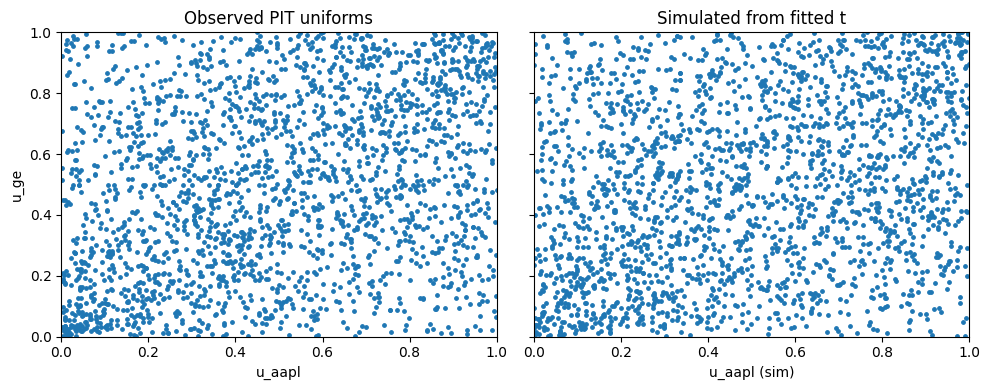

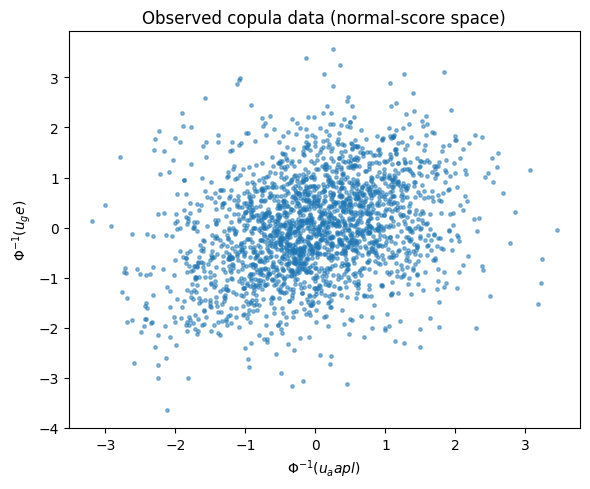


Selected copula fit:
  family: t
  params: {'rho': 0.3076612632763588, 'nu': 8.0}
  ll=120.927154, AIC=-237.854309, n=2263
  implied tail dep: lambda_L=0.056905, lambda_U=0.056905

Empirical tail co-movement proxies (conditional):
       q  lambda_L_hat  lambda_U_hat  count_L  count_U
0.100000      0.320833      0.186364      240      220
0.050000      0.244604      0.106796      139      103
0.020000      0.176471      0.000000       51       35


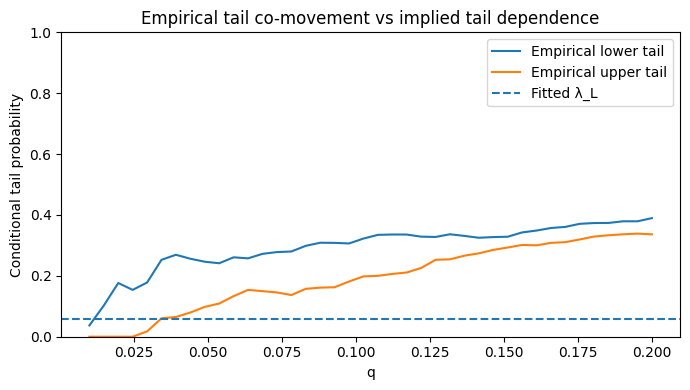

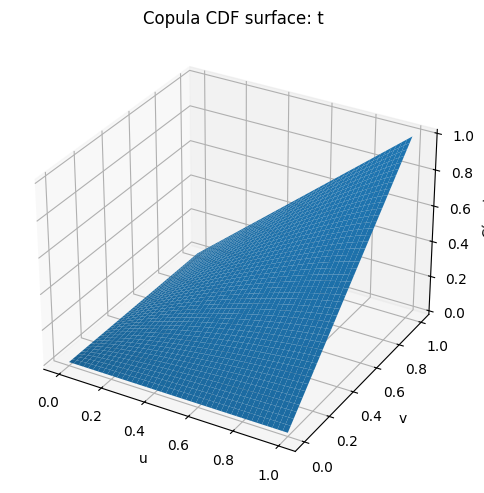

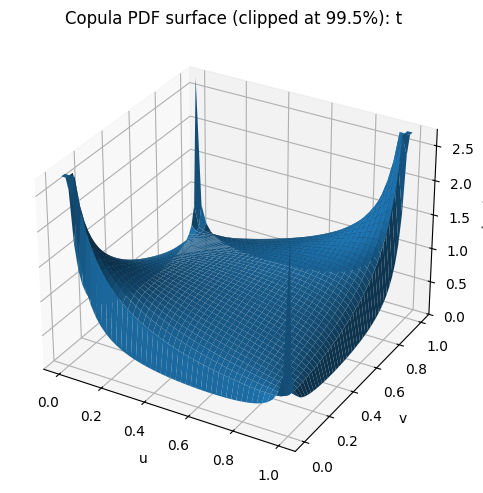


Book-style description (draft):
- Student-t copula selected (AIC-best among tested).
- ρ ≈ 0.308, ν ≈ 8.0.
- Implies symmetric tail dependence λ_L=λ_U≈0.057.
- Interpretation: moderate dependence with joint-tail co-movement beyond Gaussian.


In [165]:
# -------------------------
# Usage
# -------------------------

# Auto-pick best AIC:
visualize_copula_fit(U, "u_aapl", "u_ge", results, family="auto")

# Or explicitly pick:
# visualize_copula_fit(U, "u_aapl", "u_ge", results, family="gaussian")
# visualize_copula_fit(U, "u_aapl", "u_ge", results, family="clayton")
# visualize_copula_fit(U, "u_aapl", "u_ge", results, family="frank")
